# empiriciSN Demo

This is under construction and will be updated.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import corner

from empiriciSN import empiriciSN

(Create empiricisn object, load models.)

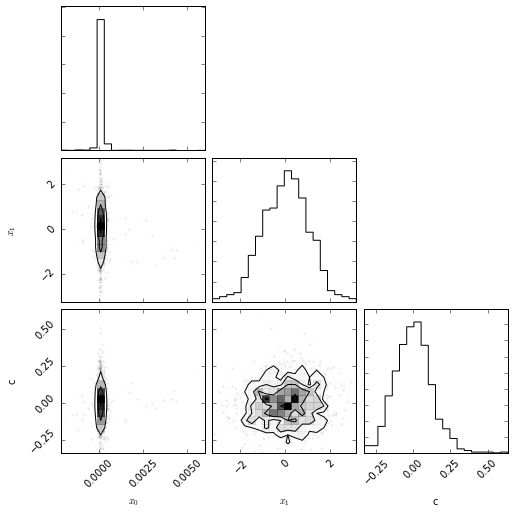

In [51]:
np.random.seed(0)
test_SNE = emp7.XDGMM.sample(1000)
figure=corner.corner(test_SNE[:,0:3],labels=['$x_0$','$x_1$','c'])

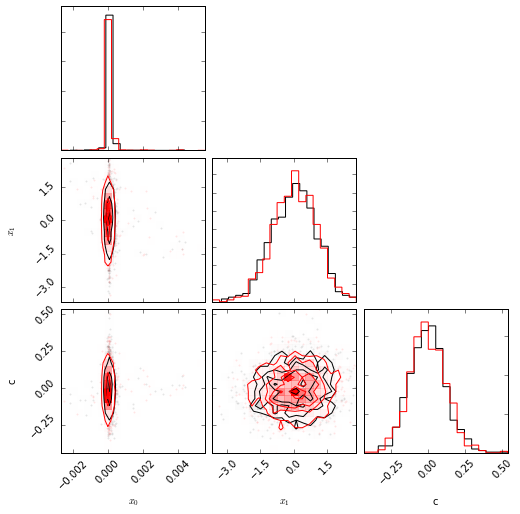

In [52]:
np.random.seed()
sample_SNe = []
for SN in test_SNE:
    X=np.append(np.array([np.nan,np.nan,np.nan]),SN[3:])
    sample_SNe.append(emp7.get_SN(X)[0])
sample_SNe = np.array(sample_SNe)
figure1=corner.corner(sample_SNe[:,0:3],labels=['$x_0$','$x_1$','c'],color='red',fig=figure)
figure1

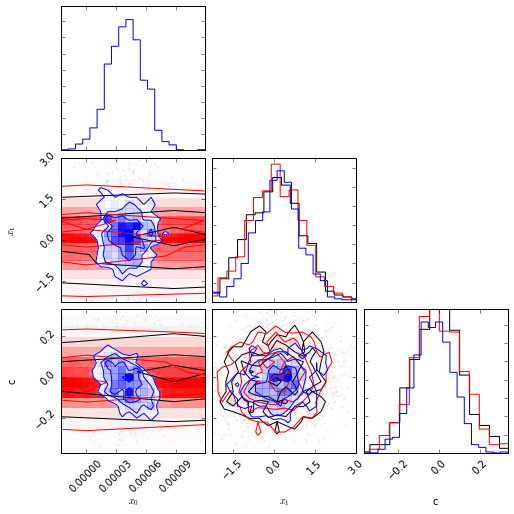

In [53]:
SN = np.append(np.array([np.nan,np.nan,np.nan]),test_SNE[1][3:])
sample_SNe = emp7.get_SN(SN,n_SN=1000)
figure2=corner.corner(sample_SNe[:,0:3],labels=['$x_0$','$x_1$','c'],color='blue',fig=figure)
figure2

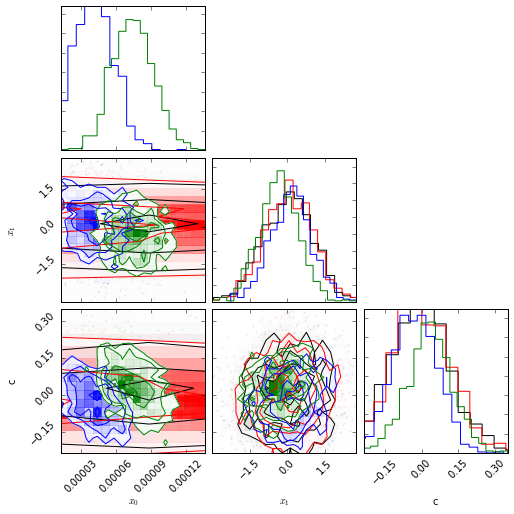

In [54]:
plt.clf()
SN = np.append(np.array([np.nan,np.nan,np.nan]),test_SNE[5][3:])
sample_SNe = emp7.get_SN(SN,n_SN=1000)
figure3=corner.corner(sample_SNe[:,0:3],labels=['$x_0$','$x_1$','c'],color='green',fig=figure)
figure3

Looks like 7 works better.